In [1]:
import json
import time

import cv2
import numpy as np
import pymongo
from scipy.spatial import KDTree

from ir_utils import *

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
db_cfg_path='./config/database.json'
connect_name='mongodb'
extr_cfg_path='./config/feature_extractor.json'
list_features=['deep_representation_4']
testset_path = './data/cifar-10/test.json'
trainset_path = './data/cifar-10/train.json'

In [3]:
with open(db_cfg_path) as f:
    db_config = json.load(f)
db_config = db_config[connect_name]
del db_config['name']
client = pymongo.MongoClient(**db_config)
db = client.image_retrieval
collection = db.image_features
collection = collection.find()
collection = list(collection)

with open(extr_cfg_path) as f:
    extractors_cfg = json.load(f)

extractors_dict = dict()

for extractor_cfg in extractors_cfg:
    extractors_dict[extractor_cfg['name']] = extractor_cfg
    
extractors = []
for ft in list_features:
    extractors.append(create_extractor(extractors_dict[ft])['extractor'])
    
pca = PCA(n_components=2)

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

all_classes = ['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
          'ship', 'truck']

class_ids = dict()

for i, c in enumerate(all_classes):
    class_ids[c] = i

def get_features(extractors, image):
    features = [extractor.extract(image) for extractor in extractors]
    features = np.concatenate(features)
    return features

def extract_features_and_classes(dataset_des, extractors):
    features = [get_features(extractors, cv2.imread(des['image_path'])) for des in dataset_des]
    classes = [des['image_path'].split('/')[-2] for des in dataset_des]
    return features, classes

def visualize(features, classes, visualized_classes=all_classes):
    pca.fit(features)
    pca_features = pca.transform(features)
    plt_colors = [colors[class_ids[c]] for c in classes]
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5, forward=True)
    for c in visualized_classes:
        x = []
        y = []
        color = colors[class_ids[c]]
        label = c
        for i in range(pca_features.shape[0]):
            if classes[i] == c:
                x.append(pca_features[i, 0])
                y.append(pca_features[i, 1])
        ax.scatter(x, y, c=color, label=label)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid()
    
    plt.show()

500


D:\MyProjects\Study_at_HUST\2020-2\thi_giac_may_tinh\image_retrieval\venv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


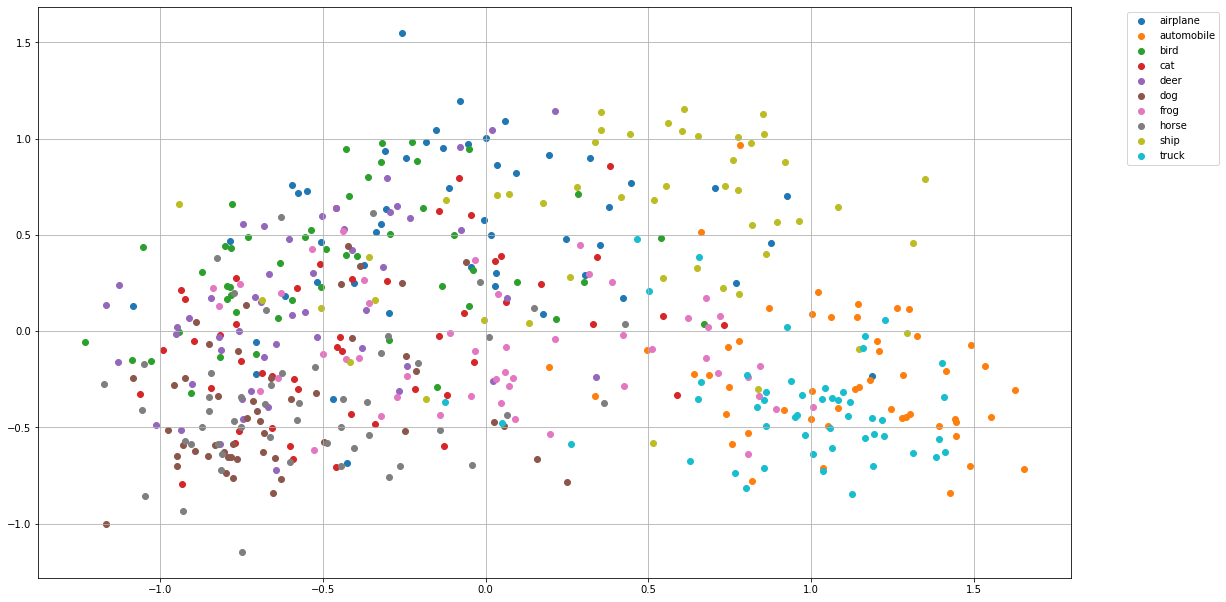

In [5]:
with open(testset_path) as f:
    testset_des = json.load(f)
    
with open(trainset_path) as f:
    trainset_des = json.load(f)
    
data_des = trainset_des + testset_des
# data_des = trainset_des
# data_des = testset_des

data_size = 500
idx_mul = len(data_des) // data_size
data_des = [data_des[i * idx_mul] for i in range(data_size)]
print(len(data_des))
    
features, classes = extract_features_and_classes(data_des, extractors)

visualized_class = all_classes
visualize(features, classes, visualized_class)

<AxesSubplot:>

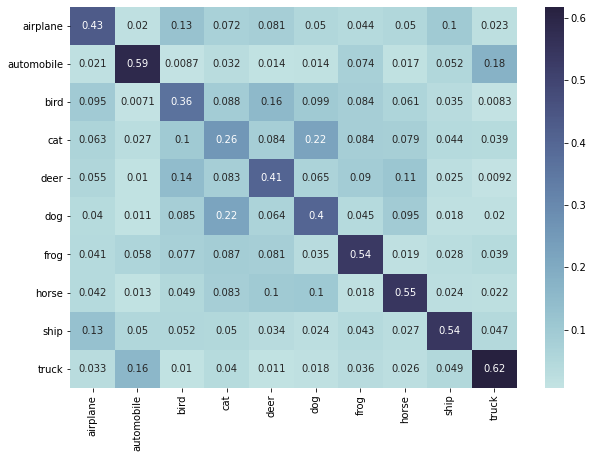

In [6]:
cm = [
    [0.4325,0.0197,0.1261,0.0718,0.0811,0.0504,0.0444,0.0503,0.1009,0.0228],
    [0.0206,0.5884,0.0087,0.0317,0.0139,0.0144,0.074,0.0165,0.0524,0.1794],
    [0.0954,0.0071,0.3644,0.0885,0.1564,0.0992,0.0841,0.0612,0.0354,0.0083],
    [0.0628,0.027,0.1006,0.2582,0.0836,0.2217,0.0843,0.0788,0.0438,0.0392],
    [0.0554,0.0102,0.1442,0.0826,0.4061,0.0648,0.0899,0.1122,0.0254,0.0092],
    [0.0398,0.0105,0.0854,0.2195,0.0644,0.4023,0.0451,0.0952,0.0177,0.0201],
    [0.0408,0.0581,0.0767,0.0875,0.0813,0.0345,0.5351,0.0188,0.0283,0.0389],
    [0.0415,0.0131,0.0489,0.0832,0.1016,0.1027,0.0182,0.5452,0.024,0.0216],
    [0.1279,0.0503,0.0523,0.0495,0.034,0.0241,0.0435,0.0271,0.5444,0.0469],
    [0.0327,0.1606,0.0101,0.0396,0.0112,0.0175,0.0363,0.0258,0.0491,0.6171],
]
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = [i for i in all_classes],
                  columns = [i for i in all_classes])
plt.figure(figsize = (10,7))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.heatmap(df_cm, annot=True, cmap=cmap)